In [1]:
import pandas as pd
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.externals import joblib
from sklearn import preprocessing

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading in Accelerometer Data

In [2]:
#df = pd.read_pickle('accelerometer_sample.pkl')
df = pd.read_csv('Activity recognition exp/Phones_accelerometer_sample.csv')
df.drop(columns=["Index"], inplace=True)

In [3]:
df.head()

,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt
0,1424777384227,343386644344000,-2.375048,-3.361459,11.856087,i,s3,s3_2,NaN
1,1424697875380,1424697873381898038,-5.292877,-0.084366,5.001587,a,nexus4,nexus4_1,stairsup
2,1424686841907,265125844797000,-1.934515,1.762132,9.184157,g,s3,s3_2,stand
3,1424694880646,1424696726699061486,-5.533127,0.037476,6.810471,c,nexus4,nexus4_2,stairsdown
4,1424780812218,346334019728000,-0.957681,0.124498,8.734048,f,s3,s3_2,bike


### checking for strangeness

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Arrival_Time     100000 non-null int64
Creation_Time    100000 non-null int64
x                100000 non-null float64
y                100000 non-null float64
z                100000 non-null float64
User             100000 non-null object
Model            100000 non-null object
Device           100000 non-null object
gt               86331 non-null object
dtypes: float64(3), int64(2), object(4)
memory usage: 6.9+ MB


In [5]:
#check for nulls
df.isnull().sum()

Arrival_Time         0
Creation_Time        0
x                    0
y                    0
z                    0
User                 0
Model                0
Device               0
gt               13669
dtype: int64

### checking class balance

In [6]:
df['gt'].value_counts()

walk          16973
sit           15324
stand         14334
bike          14019
stairsup      13595
stairsdown    12086
Name: gt, dtype: int64

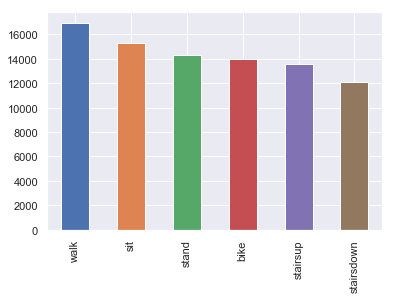

In [7]:
#look at distribution of classes in this dataset
df['gt'].value_counts().plot(kind='bar')

all classes look mostly balanced, so our accuracy metric will be fairly representative of actual performance and we should(hopefully) have enough data to predict all classes

In [8]:
#explore each column
df['Arrival_Time'].describe()

count    1.000000e+05
mean     1.424745e+12
std      4.391814e+07
min      1.424687e+12
25%      1.424697e+12
50%      1.424778e+12
75%      1.424783e+12
max      1.424789e+12
Name: Arrival_Time, dtype: float64

In [9]:
df['Creation_Time'].describe()

count    1.000000e+05
mean     6.838431e+17
std      7.117408e+17
min      4.559123e+11
25%      5.546881e+13
50%      3.508936e+14
75%      1.424778e+18
max      1.424791e+18
Name: Creation_Time, dtype: float64

In [10]:
df['x'].describe()

count    100000.000000
mean         -1.696446
std           3.860422
min         -25.542694
25%          -4.002548
50%          -2.139908
75%          -0.153227
max          17.008198
Name: x, dtype: float64

In [11]:
df['y'].describe()

count    100000.000000
mean          0.161504
std           1.557225
min         -13.222824
25%          -0.699107
50%           0.153227
75%           1.044373
max          10.218452
Name: y, dtype: float64

In [12]:
df['z'].describe()

count    100000.000000
mean          8.930146
std           2.247319
min          -1.455675
25%           7.743394
50%           9.074203
75%           9.914673
max          28.986008
Name: z, dtype: float64

In [13]:
df['User'].value_counts()

e    12430
g    12144
i    11922
b    11763
f    10586
a    10497
h    10380
c    10162
d    10116
Name: User, dtype: int64

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


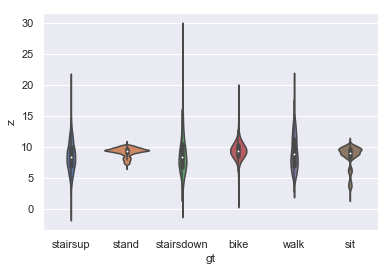

In [14]:
sns.violinplot(data=df, x='gt', y='z')

it looks like most of these are distributed around 9.8(gravity!), so the units are m/s2.
This is weird, because most sensors are in units of 'g's and unless they never rotated their phones, this is somehow compensating for rotation (gyroscope)... this is not raw accelerometer data.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


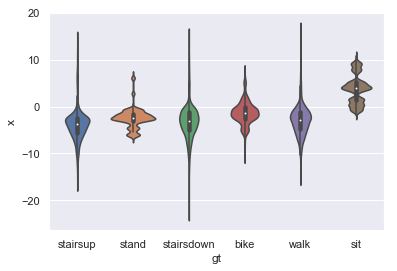

In [15]:
sns.violinplot(data=df, x='gt',y='x')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


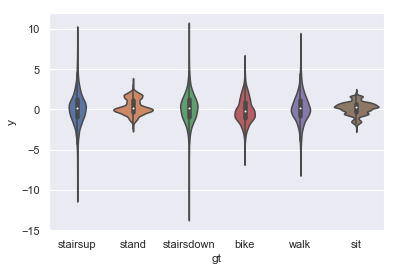

In [16]:
sns.violinplot(data=df, x='gt', y='y')

In [4]:
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time'], unit='ms')
df.set_index(['User','Arrival_Time'], inplace=True)
df.sort_index(inplace=True)

In [18]:
def leave_one_out_split(X,y):
    X_train = X[X['User_g'] == 0]
    X_test = X[X['User_g'] == 1]
    y_train = y[X['User_g'] == 0]
    y_test = y[X['User_g'] == 1]
    return X_train,X_test,y_train,y_test

In [19]:
def time_train_test_split(X,y):
    X.sort_values('Arrival_Time', inplace=True)

In [6]:
# X = pd.get_dummies(df[['Arrival_Time','Creation_Time','x','y','z','User','Model','Device']])
# y = df['gt'].fillna('null')
# X_train, X_test, y_train, y_test = train_test_split(X,y)
X = pd.get_dummies(df[['x','y','z']])
y = df['gt'].fillna('null')
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

# checking our model intuition and baselining

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


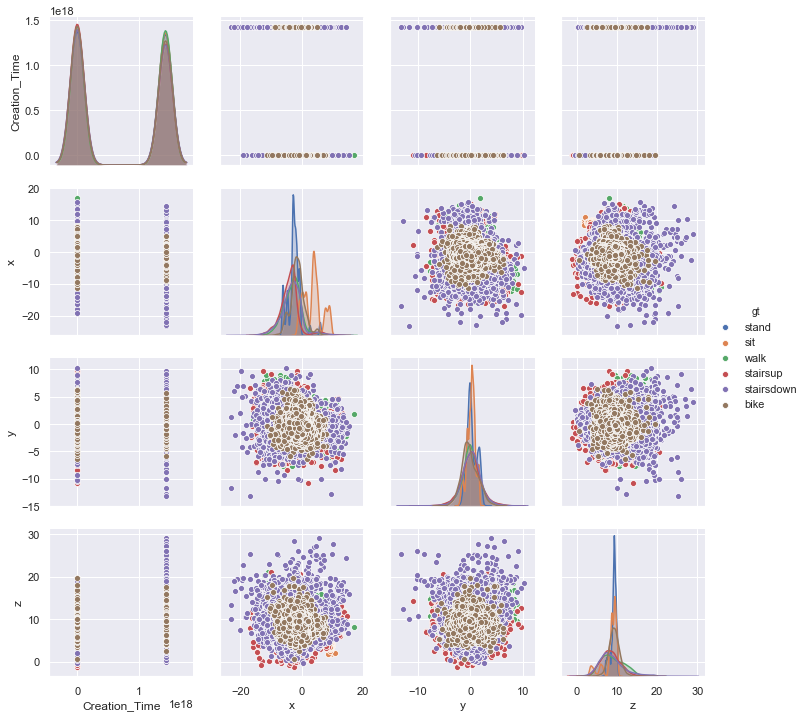

In [5]:
sns.pairplot(df, hue='gt')

Looking at the class distributions in the pairplots, these graphs are clearly high variance and low bias. This is the exact situation in which a randomforest model would excel. 

## Random Forest Baseline

In [22]:
rf_model_base = RandomForestClassifier()
rf_model_base.fit(X_train, y_train)
rf_model_base.score(X_test, y_test)

0.51452

In [23]:
cross_val_score(rf_model_base,X_test,y_test)

array([0.50635797, 0.50174007, 0.5053415 ])

In [24]:
print(classification_report(y_test,rf_model_base.predict(X_test)))

             precision    recall  f1-score   support

       bike       0.44      0.52      0.48      3497
       null       0.28      0.23      0.26      3444
        sit       0.92      0.96      0.94      3832
 stairsdown       0.29      0.27      0.28      2950
   stairsup       0.33      0.31      0.32      3441
      stand       0.80      0.88      0.84      3665
       walk       0.37      0.35      0.36      4171

avg / total       0.50      0.51      0.51     25000



### drop null class

In [6]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 86331 entries, (a, 2015-02-23 13:03:54.007000) to (i, 2015-02-24 11:49:13.138000)
Data columns (total 7 columns):
Creation_Time    86331 non-null int64
x                86331 non-null float64
y                86331 non-null float64
z                86331 non-null float64
Model            86331 non-null object
Device           86331 non-null object
gt               86331 non-null object
dtypes: float64(3), int64(1), object(3)
memory usage: 5.8+ MB


In [26]:
X = df[['x','y','z']]
y = df['gt']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [27]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6028355650280314

In [28]:
print(classification_report(y_test,model.predict(X_test)))

             precision    recall  f1-score   support

       bike       0.49      0.59      0.54      3454
        sit       0.97      0.99      0.98      3945
 stairsdown       0.33      0.28      0.31      3009
   stairsup       0.40      0.36      0.38      3449
      stand       0.84      0.92      0.88      3576
       walk       0.44      0.41      0.42      4150

avg / total       0.59      0.60      0.60     21583



In [29]:
np.mean(cross_val_score(model,X_test,y_test))

0.5919937744456193

In [11]:
def plot_importances(x, model):
    plt.figure(figsize=(20,10))
    plt.barh(X_train.columns, model.feature_importances_)
plot_importances(X_train, rf_model_base)

NameError: name 'rf_model_base' is not defined

In [32]:
#joblib.dump(model, 'activity_classifier_acc.pkl') 

didn't seem to help much, let's leave it alone for now

In [8]:
def plot_learning_curve(X, Y, model, cv=5, train_sizes=np.linspace(.1, 1.0, 15)):

    plt.figure(figsize=(10,5))
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

## adding more features

### Time domain features

In [38]:
df.head()

Creation_Time         x         y  \
User Arrival_Time                                                       
a    2015-02-23 13:03:54.007  1424696632014017615 -5.892731  0.682114   
     2015-02-23 13:03:54.232  1424696632240580115 -5.928436  0.630936   
     2015-02-23 13:03:55.232  1424696633241088890 -5.770142  0.907059   
     2015-02-23 13:03:55.558       10352941219000  6.129080 -1.072589   
     2015-02-23 13:03:56.184  1424698482250901934 -5.665237  0.987244   

                                     z       Model        Device     gt  
User Arrival_Time                                                        
a    2015-02-23 13:03:54.007  8.155579      nexus4      nexus4_1  stand  
     2015-02-23 13:03:54.232  8.116302      nexus4      nexus4_1  stand  
     2015-02-23 13:03:55.232  8.203186      nexus4      nexus4_1  stand  
     2015-02-23 13:03:55.558  8.121031  samsungold  samsungold_2  stand  
     2015-02-23 13:03:56.184  7.849503      nexus4      nexus4_2  stand

In [7]:
df[['std_x','std_y','std_z']] = df[['x','y','z']].groupby(level='User', group_keys=False).rolling(1000).std()[['x','y','z']]

In [40]:
df[['mean_x','mean_y','mean_z']] = df[['x','y','z']].groupby(level='User', group_keys=False).rolling(1000).mean()[['x','y','z']]

In [41]:
df.head()

Creation_Time         x         y  \
User Arrival_Time                                                       
a    2015-02-23 13:03:54.007  1424696632014017615 -5.892731  0.682114   
     2015-02-23 13:03:54.232  1424696632240580115 -5.928436  0.630936   
     2015-02-23 13:03:55.232  1424696633241088890 -5.770142  0.907059   
     2015-02-23 13:03:55.558       10352941219000  6.129080 -1.072589   
     2015-02-23 13:03:56.184  1424698482250901934 -5.665237  0.987244   

                                     z       Model        Device     gt  \
User Arrival_Time                                                         
a    2015-02-23 13:03:54.007  8.155579      nexus4      nexus4_1  stand   
     2015-02-23 13:03:54.232  8.116302      nexus4      nexus4_1  stand   
     2015-02-23 13:03:55.232  8.203186      nexus4      nexus4_1  stand   
     2015-02-23 13:03:55.558  8.121031  samsungold  samsungold_2  stand   
     2015-02-23 13:03:56.184  7.849503      nexus4      nexus4_2  stand   

                              std_x  std_y  std_z  mean_x  mean_y  mean_z  
User Arrival_Time                                                          
a    2015-02-23 13:03:54.007    NaN    NaN    NaN     NaN     NaN     NaN  
     2015-02-23 13:03:54.232    NaN    NaN    NaN     NaN     NaN     NaN  
     2015-02-23 13:03:55.232    NaN    NaN    NaN     NaN     NaN     NaN  
     2015-02-23 13:03:55.558    NaN    NaN    NaN     NaN     NaN     NaN  
     2015-02-23 13:03:56.184    NaN    NaN    NaN     NaN     NaN     NaN

In [9]:
df.dropna(inplace=True)
# X = df[['x','y','z','std_x','std_y','std_z','mean_x','mean_y','mean_z']]
X = df[['x','y','z','std_x','std_y','std_z']]
y = df['gt']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
model.score(X_test, y_test)


0.9658132919575899

In [48]:
np.mean(cross_val_score(model,X_train,y_train))

0.9883112953832377

huge increase!

In [45]:
print(classification_report(y_test,model.predict(X_test)))

             precision    recall  f1-score   support

       bike       1.00      1.00      1.00      3385
        sit       1.00      1.00      1.00      3552
 stairsdown       0.97      0.98      0.98      2993
   stairsup       0.98      0.98      0.98      3461
      stand       1.00      1.00      1.00      1641
       walk       1.00      1.00      1.00      4303

avg / total       0.99      0.99      0.99     19335



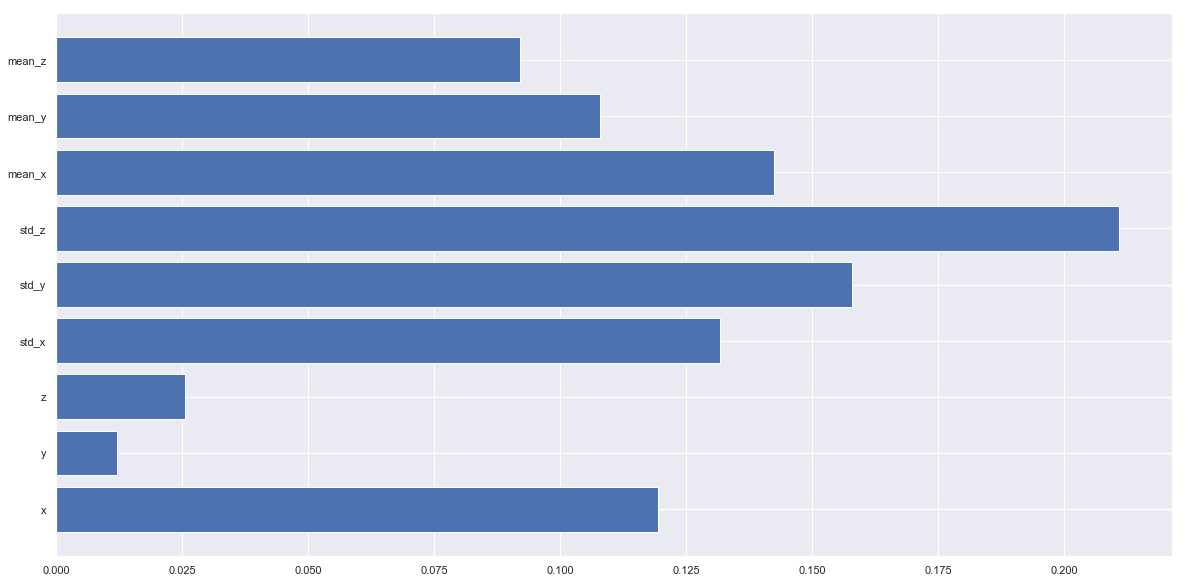

In [46]:
plot_importances(X_train,model)

In [10]:
joblib.dump(model, 'activity_classifier_acc.pkl') 

['activity_classifier_acc.pkl']

let's do some grouping and get some more features

## including gyroscope data

In [ ]:
df_gyroscope = pd.read_csv('Activity recognition exp/Phones_gyroscope_sample.csv')
df_gyroscope.drop(columns=["Index"], inplace=True)

In [ ]:
df_gyroscope.info()

In [ ]:
df_gyroscope.isnull().sum()

In [ ]:
df_gyroscope.dropna(inplace=True)

In [ ]:
# X = pd.get_dummies(df_gyroscope[['Arrival_Time','Creation_Time','x','y','z','User','Model','Device']])
# y = df_gyroscope['gt']
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X = pd.get_dummies(df_gyroscope[['x','y','z']])
y = df_gyroscope['gt']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)


### testing  gyroscope data predictability

In [ ]:
rf_model_gyroscope = RandomForestClassifier()

In [ ]:
rf_model_gyroscope.fit(X_train,y_train)
rf_model_gyroscope.score(X_test,y_test)

In [ ]:
print(classification_report(y_test,rf_model_gyroscope.predict(X_test)))

In [ ]:
plot_importances(X_train, rf_model_gyroscope)

# Merging gyroscope and accelerometer

## looking at the timeseries data

In [ ]:
# user_acc = df[(df['User']=='a') & (df['Device']=='nexus4_1')]
# user_acc.sort_values('Arrival_Time', inplace=True)
# user_acc.plot(x='Arrival_Time',y='y', figsize=(20,5));
# user_gyr = df_gyroscope[(df_gyroscope['User']=='a') & (df_gyroscope['Device']=='nexus4_1')]
# user_gyr.sort_values('Arrival_Time', inplace=True)
# user_gyr.plot(x='Arrival_Time',y='y', figsize=(20,5));

#### data seems to line up, let's look a little closer

let's check to see if gyroscope and accelerometer data have the same sampling rate, so we can just shift them to line them up?

In [ ]:
# user_acc['Last_Sample_Arrival'] = user_acc['Arrival_Time'].shift()
# user_acc['Time_Since_Last_Sample'] = user_acc['Arrival_Time'] - user_acc['Last_Sample_Arrival']
# user_acc.head()

In [ ]:
# user_acc['Time_Since_Last_Sample'].describe()

In [ ]:
# print('# of accelerometer:',len(user_acc))
# print('# of gyroscope:', len(user_gyr))

# print('\nstart of accelerometer:{} ns'.format(user_acc['Arrival_Time'].min()))
# print('start of gyroscope:{} ns'.format(user_gyr['Arrival_Time'].min()))
# print('difference:{} ns'.format(user_acc['Arrival_Time'].min() - user_gyr['Arrival_Time'].min()))

# print('\nend of accelerometer:{} ns'.format(user_acc['Arrival_Time'].max()))
# print('end of gyroscope:{} ns'.format(user_gyr['Arrival_Time'].max()))
# print('difference:{} ns'.format(user_acc['Arrival_Time'].max() - user_gyr['Arrival_Time'].max()))


In [ ]:
# df.sort_values('Arrival_Time').head(10)

a little off, maybe we can do a rolling window and group into ms and average (resample?)?

### Merging by Rounding

it looks like they mostly line up to 10 decimal places in Arrival_Time, so let's create a new column rounded to there and try to merge on it

In [ ]:
# df['Arrival_Time_round'] = df['Arrival_Time'].round(-3)
# df.head()
# df_gyroscope['Arrival_Time_round'] = df_gyroscope['Arrival_Time'].round(-3)

In [ ]:
# df = df.merge(df_gyroscope, on=['Arrival_Time_round','User','Device','Model','gt'], suffixes = ['_acc','_gyr'])
# df.info()

In [ ]:
# df.head()

looks like we ended up with some duplicates, but that's okay. let's drop them

In [ ]:
# df.drop_duplicates(subset='Creation_Time_acc',inplace=True)
# df.reset_index(drop=True,inplace=True)
# df.info()

## looking at effects of data size

In [ ]:
from sklearn.model_selection import learning_curve

In [9]:
plot_learning_curve(X_train, y_train, model)

NameError: name 'model' is not defined

this looks like it might still benefit from more data, so we will move on to the full 43,000,000 rows in the next notebook using sql and aws

In [ ]:
joblib.dump(model, 'activity_classifier.pkl') 